In [1]:
#import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim
import torch.nn.functional as F

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the `lfw.zip` file . Adjust the `path` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Adjusting the path variable
path = '/content/drive/My Drive/Autoencoders Assignment/lfw'

In [4]:
#creating a dataloader from lfw folder
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.


In [6]:
#searching for cuda or mps device is present on the laptop
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("MPS device not found.")

torch.Size([250, 250, 3])


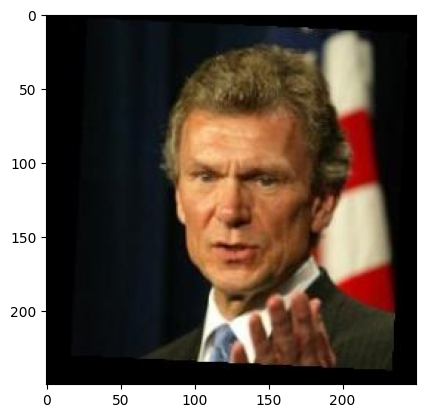

In [7]:
#getting a random image from the dataloader and displaying
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

From the above image, Torch size is (250,250,3)-> This represents height and width of the image are 250px and number of channels are 3.

## Step 2

Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.


In [8]:
# Iterating over the data loader and getting a batch of data
data_iterate = iter(dataloader)
images, labels = next(data_iterate)

# Print dimensions of the sample image in the batch. I am taking here the first image as the sample image.
print("Image dimensions:", images[0].shape)

Image dimensions: torch.Size([3, 250, 250])


Explanation of the dimensions:

The images tensor is of shape (channels, height, width).

1. channels: The number of color channels in the image. Channels namely Red, Green, Blue i.e., RGB.
2. height: The height of the image in pixels.
3. width: The width of the image in pixels.

For example, we can see above that torch.Size([3, 250 250]):

It means we have an image with 3 color channels (RGB) and a resolution of 250pixels in height and 250pixels in width.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**


Below code shows an autoencoder class in PyTorch with separate functions for the encoder and decoder, utilizing Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d, and Linear layers, along with ReLU activation functions.

In [9]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.encoder_relu1 = nn.ReLU()
        self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(128)
        self.encoder_relu2 = nn.ReLU()
        self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(256)
        self.encoder_relu3 = nn.ReLU()
        self.encoder_maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_bn1 = nn.BatchNorm2d(128)
        self.decoder_relu1 = nn.ReLU()

        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_bn2 = nn.BatchNorm2d(64)
        self.decoder_relu2 = nn.ReLU()

        self.decoder_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, output_padding=1)
        self.decoder_sigmoid = nn.Sigmoid()

    def encoder(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)
        x = self.encoder_maxpool1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)
        x = self.encoder_maxpool2(x)

        x = self.encoder_conv3(x)
        x = self.encoder_bn3(x)
        x = self.encoder_relu3(x)
        x = self.encoder_maxpool3(x)

        return x

    def decoder(self, x):
        x = self.decoder_conv1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)

        x = self.decoder_conv2(x)
        x = self.decoder_bn2(x)
        x = self.decoder_relu2(x)

        x = self.decoder_conv3(x)
        x = self.decoder_sigmoid(x)

        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

An encoder and a decoder are part of the architecture. Here's a quick rundown of the architecture:

Encoder Layers:
* Layer 1:
1. Convolutional layer with 3 input channels and 64 output channels.
2. Normalization of the batches and activation function is ReLU.
3. Max-pooling layer with a stride of 2 and a kernel size of 2.

* Layer 2:
1. 64 input channels and 128 output channels in a convolutional layer.
2. Normalization of the batches and activation function is ReLU.
3. Max-pooling layer with a stride of 2 and a kernel size of 2.

* Layer 3:
1. 128 input channels and 256 output channels in a convolutional layer.
2. Normalization of the batches and activation function is ReLU.
3. Max-pooling layer with a stride of 2 and a kernel size of 2.

Decoder Layers:
* Layer 1:
1. Convolutional layer with 256 input channels and 128 output channels that has been transposed.
2. Normalization of batches and activation function is ReLU.

* Layer 2:
1. Convolutional layer with 128 input channels and 64 output channels that has been transposed.
2. Normalization of batches and activation function is ReLU.

* Layer 3:
1. Convolutional layer transposed with 64 input channels and 3 output channels.
2. Sigmoid is the activation function.

* Encoder Method: Calls the encoder method to obtain the latent representation.
* Decoder Method: Calls the decoder method to reconstruct the input.
* Forward Method: forward function calls the both encoder and decoder functions.


## Step 4

Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.


In [10]:
# Create an instance of the AE model
model = AE()

# Print the model architecture
print(model)

# Select a single image from the batch for testing
test_input = images[25]

# If the image is a batch, unsqueeze to add a batch dimension
test_input = test_input.unsqueeze(0)

# Forward pass through the model
output = model(test_input)

# Get the output of the encoder and decoder
encoded_output = model.encoder(test_input)
decoded_output = model.decoder(encoded_output)

# Print the shapes of the outputs
print("Shape of the input image:", test_input.shape)
print("Shape of the encoded output:", encoded_output.shape)
print("Shape of the decoded output:", decoded_output.shape)

AE(
  (encoder_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_relu1): ReLU()
  (encoder_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_relu2): ReLU()
  (encoder_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_relu3): ReLU()
  (encoder_maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2

1. Autoencoder is nothing but it compresses the size of the image to the lower dimesions.
2. Decoder is nothing but it reconstructs to the size of the original input image.
3. Above, we can see the input image size is (1,3,250,250) where 1 is the batch size, the number of channel are 3, height and width of the image are 250px.
4. Autoencoder Output dimesion is (1,256,31,31) where the batch size is 1, the number of channels are 256, height and width of the image are 31px. We can see that the autoencoder output image dimensions are reduced.
5. Decoder Output dimesion is (1,3,250,250) where the batch size is 1, the number of channels are 3, height and width of the image are 250px. We can see that the decoder output image has been reconstructed to the size of original input image.

Thus, the test image ensures that our model's forward path is working as expectedly.




## Step 5

Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training


The total number of parameters for my model are 537859. This number tells as the quantity of weights and biases which will be adjusted while in training process.

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 537859


For the optimizer, I am using the optimizer "Adam". I used this for its efficiency in deep learning models. The learning rate used in my model is 0.001.

In [12]:
optim = optim.Adam(model.parameters(), lr=0.001)

For the loss function, I am working on an image reconstruction task with pixel values, the best choice is the Mean Squared Error (MSE) loss. The MSE loss is defined as the average squared difference between the input and output images.

In [13]:
loss_function = nn.MSELoss()

## Step 6

Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?


The number of epochs in my model is 10. The loss decreased absolutely for each epoch.

If loss is not decreasing, then learning rate should be altered, adjust the batch size, ensure input data is normalized and scaled, implement early stopping based on the loss, expermient with different optimizers, and implement gradient clipping to prevent exploding gradients. In this ways, we can troubleshoot the model.

In [15]:
# Number of training epochs
model=model.to(device)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    running_loss = 0.0
    for images, _ in dataloader:
        # Forward passing
        images = images.to(device)
        outputs = model(images)
        loss = loss_function(outputs, images)

        # Backward and optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss.item()

    # Calculating average loss for each epoch
    average_loss = running_loss / len(dataloader)

    # Printing the average loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}')

Epoch [1/10], Loss: 0.002688636971676866
Epoch [2/10], Loss: 0.0023424731738171793
Epoch [3/10], Loss: 0.00228180379805262
Epoch [4/10], Loss: 0.002080982729827492
Epoch [5/10], Loss: 0.0019627679690099225
Epoch [6/10], Loss: 0.0018120733696631477
Epoch [7/10], Loss: 0.0017153029212841559
Epoch [8/10], Loss: 0.001649093931700066
Epoch [9/10], Loss: 0.0015679919368105414
Epoch [10/10], Loss: 0.0015157015494723092


## Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.


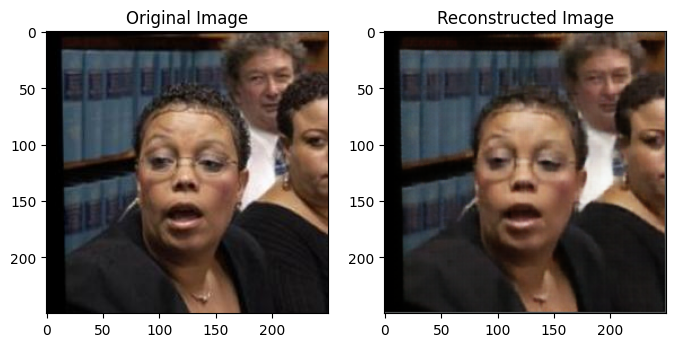

In [23]:
# Setting the model to evaluation mode
model.eval()

# Getting a random image from the dataloader
random_index = random.randint(0, len(images) - 1)
random_image = images[random_index]

# Moving the image to the device
random_image = random_image.unsqueeze(0).to(device)

# Performing the forward pass to get the reconstructed image
reconstructed_image = model(random_image)

# Move the reconstructed image back to the CPU and remove the batch dimension
random_image = random_image.squeeze().cpu()
reconstructed_image = reconstructed_image.squeeze().cpu().detach()

# Plot the original and reconstructed images side by side
plt.figure(figsize=(8, 4))

# Plotting Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(random_image.permute(1, 2, 0))

# Plotting Reconstructed Image
plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.permute(1, 2, 0))

plt.show()


## Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?


Adding noise to the latent representation of an image and then decoding it again is said to be denoising. Some of the impacts of it are:

1. Loss of Information:
* Effect: The additional noise may cause information loss in the latent representation.
* Result: Because of this loss, the reconstructed image may lack fine details and be less faithful to the original input.

2. Distortion of Important Features:
* Effect: If noise is not carefully controlled, it has the potential to distort important features in the latent space.
* Result: Because noise affects critical information in the representation, the decoded image may contain artifacts or inaccuracies.

3. Sensitivity to Noise Level:
* Effect: The impact of noise is sensitive to its magnitude.
* Result: Finding the right amount of noise to achieve denoising without causing distortion is difficult and necessitates careful parameter tuning.

4. Over-regularization:
* Effect: Excessive noise can cause over-regularization, which causes the model to be overly conservative in its reconstruction.
* Result: Important variations present in the input data may be lost in the reconstructed images, resulting in oversimplified representations.

5. Impact on Fidelity and Quality:
* Effect: It can be difficult to strike a balance between denoising and maintaining reconstruction quality.
* Result: The decoded images may suffer from a trade-off between denoising benefits and reconstruction faithfulness.

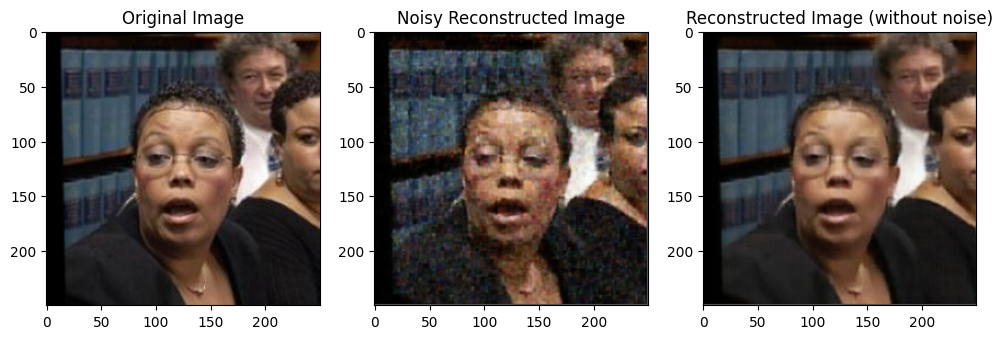

In [25]:
random_image = images[random_index]

# Moving the image to the device and add a batch dimension
random_image = random_image.unsqueeze(0).to(device)

# Performing the forward pass to get the latent representation
latent_representation = model.encoder(random_image)

# Adding more noise to the latent representation
noise_scale = 0.5 #Adjusting the scale of noise
noise = torch.randn_like(latent_representation) * noise_scale
noisy_latent_representation = latent_representation + noise

# Decode the noisy latent representation
noisy_reconstructed_image = model.decoder(noisy_latent_representation)

# Move the images back to the CPU and remove the batch dimension
sample_image = random_image.squeeze().cpu()
noisy_reconstructed_image = noisy_reconstructed_image.squeeze().cpu().detach()

# Image Sizes
plt.figure(figsize=(12, 4))

# Plotting Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(random_image.permute(1, 2, 0))  # Assuming the image is in (C, H, W) format

# Plotting Noisy Reconstructed Image
plt.subplot(1, 3, 2)
plt.title('Noisy Reconstructed Image')
plt.imshow(noisy_reconstructed_image.permute(1, 2, 0))

# Plotting Reconstructed Image Without noise
plt.subplot(1, 3, 3)
plt.title('Reconstructed Image (without noise)')
reconstructed_image = model.decoder(latent_representation)
reconstructed_image = reconstructed_image.squeeze().cpu().detach()
plt.imshow(reconstructed_image.permute(1, 2, 0))

plt.show()